In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [3]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [4]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

#'Hour', 'Day', and 'Month' created
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31)
    df = add_cyclical_features(df, 'Month', 12)

In [5]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']  # Add other relevant features as needed

# Applying the function to the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Adjust the degree of polynomial features to manage complexity
poly = PolynomialFeatures(degree=1, include_bias=False)

# Applying transformation to all datasets
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)

feature_names = poly.get_feature_names_out(input_features=train_features.columns)

y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [7]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over with adjusted ranges for simplification
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Instantiate the Random Forest regressor with a random state for reproducibility
random_forest = RandomForestRegressor(random_state=42)

# Instantiate the Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, n_jobs=-1, verbose=2)

# Fit the Grid Search to the training data using the simplified feature set
grid_search.fit(X_train_poly, y_train)

# Extract the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
from joblib import dump

# Assuming 'best_model' is the best model obtained from GridSearchCV
# Define the path where you want to save your model
model_filename = '/content/drive/MyDrive/Saved_trained_models/best_random_forest_model.joblib'

# Save the model to the specified path
dump(best_model, model_filename)

print(f"Model saved to {model_filename}")


Model saved to /content/drive/MyDrive/Saved_trained_models/best_random_forest_model.joblib


In [8]:
from joblib import load

best_model = load('/content/drive/MyDrive/Saved_trained_models/best_random_forest_model.joblib')

In [9]:
# Make predictions using the best model
final_train_pred = best_model.predict(X_train_poly)
final_validation_pred = best_model.predict(X_validation_poly)
final_test_pred = best_model.predict(X_test_poly)

# Evaluate on the training dataset
train_metrics = calculate_metrics(y_train, final_train_pred)
print('Training Metrics:')
print(f"MAE: {train_metrics[0]}")
print(f"MAPE: {train_metrics[1]}")
print(f"sMAPE: {train_metrics[2]}")
print(f"RMSE: {train_metrics[3]}\n")

# Evaluate on the validation dataset
validation_metrics = calculate_metrics(y_validation, final_validation_pred)
print('Validation Metrics:')
print(f"MAE: {validation_metrics[0]}")
print(f"MAPE: {validation_metrics[1]}")
print(f"sMAPE: {validation_metrics[2]}")
print(f"RMSE: {validation_metrics[3]}\n")

# Evaluate on the test dataset
test_metrics = calculate_metrics(y_test, final_test_pred)
print('Test Metrics:')
print(f"MAE: {test_metrics[0]}")
print(f"MAPE: {test_metrics[1]}")
print(f"sMAPE: {test_metrics[2]}")
print(f"RMSE: {test_metrics[3]}\n")

Training Metrics:
MAE: 4.341188099175185
MAPE: 6.711476320197568
sMAPE: 6.668697992450145
RMSE: 11.187632473434636

Validation Metrics:
MAE: 5.900181692807349
MAPE: 10.909863409438357
sMAPE: 10.75369990929991
RMSE: 13.139937927341444

Test Metrics:
MAE: 4.523466578313936
MAPE: 6.999777259473644
sMAPE: 7.917955652045617
RMSE: 9.032307388990231



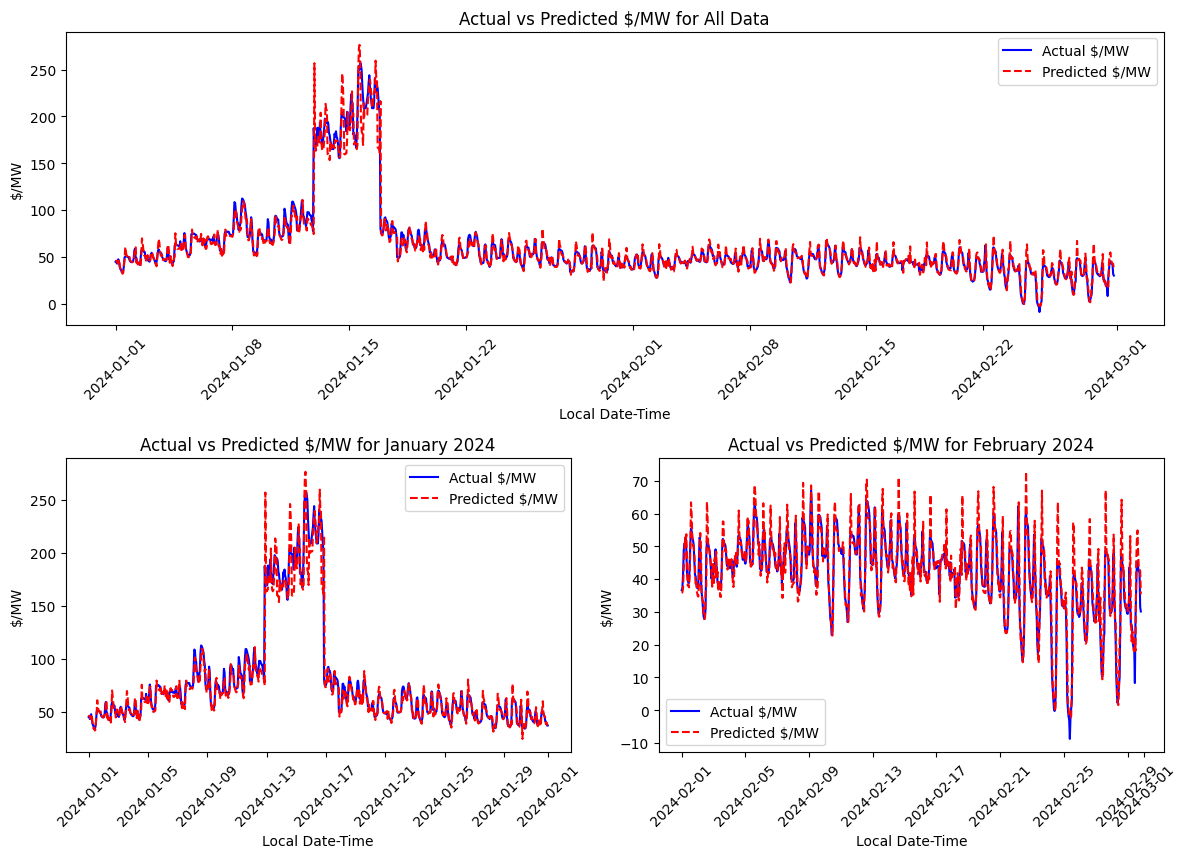

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test_pred and y_test are already defined and correspond to predictions and actual values

# Loading the 'local_time' column from the test dataset again for plotting
test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

# Make sure the lengths match
if len(test_local_time) > len(final_test_pred):
    test_local_time = test_local_time.iloc[:len(final_test_pred)]
    y_test = y_test.iloc[:len(final_test_pred)]

# Plotting setup
fig = plt.figure(figsize=(12, 12))

# Main top plot
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax1.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax1.plot(test_local_time, final_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('Actual vs Predicted $/MW for All Data')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Filtering data for January and February
january_filter = test_local_time.dt.month == 1
february_filter = test_local_time.dt.month == 2

# Bottom left plot - January
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax2.plot(test_local_time[january_filter], y_test[january_filter], label='Actual $/MW', color='blue')
ax2.plot(test_local_time[january_filter], final_test_pred[january_filter], label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('Actual vs Predicted $/MW for January 2024')
ax2.set_xlabel('Local Date-Time')
ax2.set_ylabel('$/MW')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Bottom right plot - February
ax3 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax3.plot(test_local_time[february_filter], y_test[february_filter], label='Actual $/MW', color='blue')
ax3.plot(test_local_time[february_filter], final_test_pred[february_filter], label='Predicted $/MW', color='red', linestyle='--')
ax3.set_title('Actual vs Predicted $/MW for February 2024')
ax3.set_xlabel('Local Date-Time')
ax3.set_ylabel('$/MW')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

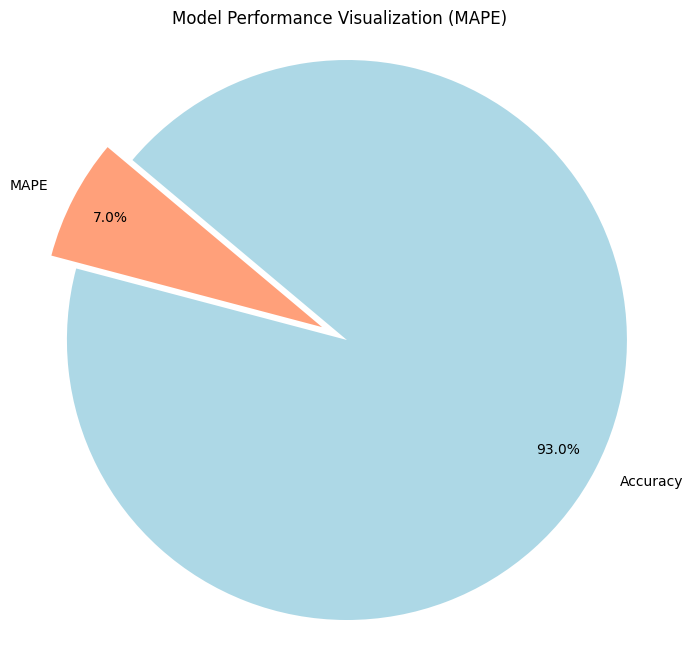

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_metrics is structured as [MAE, MAPE, sMAPE, RMSE]
mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()

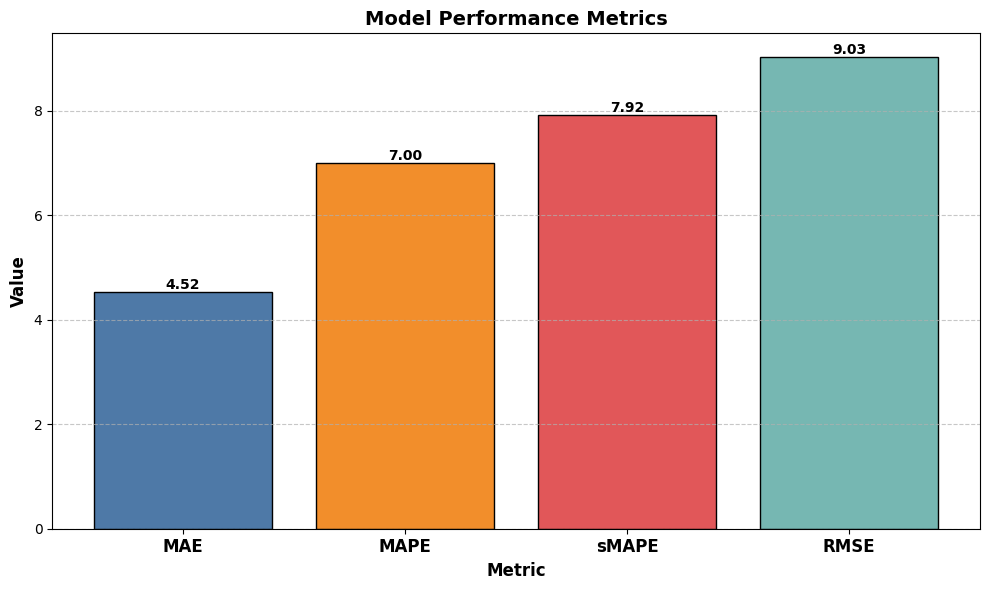

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

# Optional: Adding the value of each metric above its bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

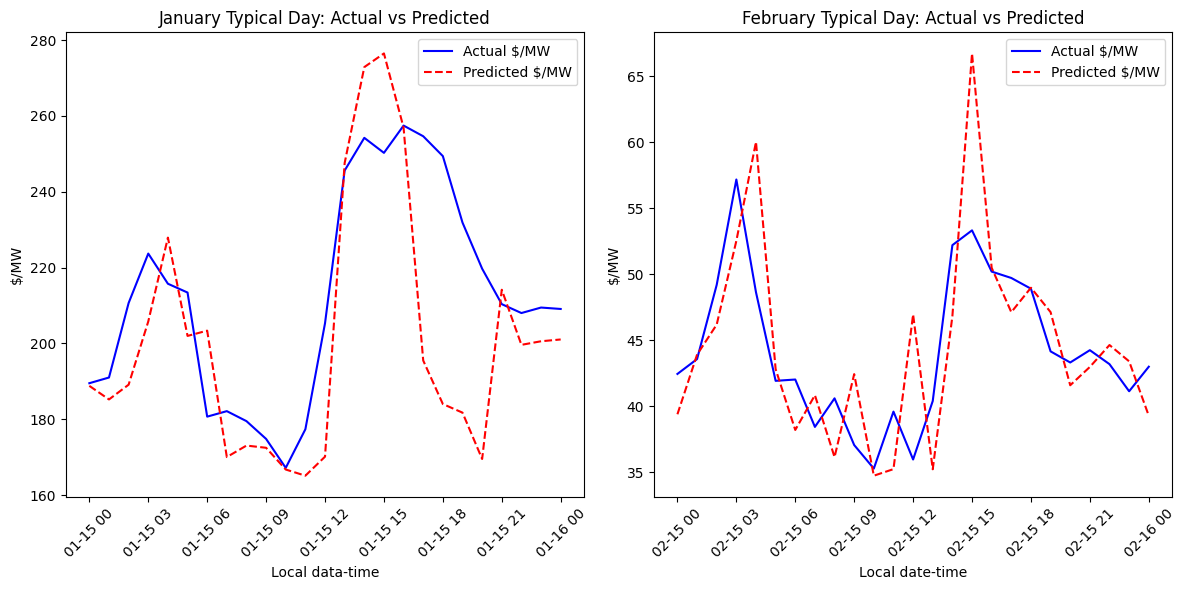

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-15"
january_end = "2024-01-16"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = final_test_pred[is_january]

# Filter for February
february_start = "2024-02-15"
february_end = "2024-02-16"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = final_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 6))  # Adjusted for a wider aspect to accommodate two columns
gs = gridspec.GridSpec(1, 2)  # Adjusted to define a grid of 1 row and 2 columns

# January subplot in the first row, first column
ax1 = plt.subplot(gs[0, 0])  # Top left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January Typical Day: Actual vs Predicted')
ax1.set_xlabel('Local data-time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# February subplot in the first row, second column
ax2 = plt.subplot(gs[0, 1])  # Top right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February Typical Day: Actual vs Predicted')
ax2.set_xlabel('Local date-time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()
